In [1]:
import imageio
import math

import numpy as np
import scipy as sp

from PIL import Image
from scipy import conj
from numpy.fft import fft2, ifft2, fftshift

# Frequency Based Registration

Registration by sending the images into the Fourier domain and performing phase correlation on them. In the Inverse Fourier transform of this operation, the peak is where the images correlate the best. The point found represents the upper left corner of the moving image instead of the center as it does in the area based methods.

An interesting note on [`scipy.fftpack.fft`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.fft.html):  
    
> This function is most efficient when n is a power of two, and least efficient when n is prime.

In [166]:
def norm_cross_power_spectrum(i1, i2):
    '''
    normalized cross power spectrum, Faroosh et. al.
    '''
    assert i1.shape[0] == i2.shape[0] and i1.shape[1] == i2.shape[1], 'images are different sizes: %s v %s' % (i1.shape, i2.shape,)
    f1 = fft2(i1)
    f2 = fft2(i2)
    return (f1 * conj(f2)) / abs(f2 * conj(f2))

def cross_power_spectrum(i1, i2):
    '''
    Cross power spectrum, 
    Image Mosaic Based on Phase Correlation and Harris Operator, F. Yang et al.
    '''
    assert i1.shape[0] == i2.shape[0] and i1.shape[1] == i2.shape[1], 'images are different sizes: %s v %s' % (i1.shape, i2.shape,)
    f1 = fft2(i1)
    f2 = fft2(i2)
    return (f1 * conj(f2)) / abs(f1 * conj(f2))

def phase_correlation(i1, i2):
    '''
    Image Alignment and Stitching: A Tutorial, R. Szeliski
    "here the spectrum of the two signals is **whitened** by dividing each per frequency product
    by the magnitudes of the Fourier transforms"
    '''
    assert i1.shape[0] == i2.shape[0] and i1.shape[1] == i2.shape[1], 'images are different sizes: %s v %s' % (i1.shape, i2.shape,)
    f1 = fft2(i1)
    f2 = fft2(i2)
    return (f1 * conj(f2)) / (abs(f1) * abs(f2))

In [156]:
from operator import mul

def apply_hamming_window(im):
    h = np.hamming(im.shape[0])
    ham2d = np.sqrt(np.outer(h,h))
    return im * ham2d

def NCC(i1, i2):
    '''
    Normalized cross correlation, maximize this
    '''
    assert sum(i1.shape) == sum(i2.shape), 'i1 and i2 are different shapes "%s" v "%s"' % (i1.shape, i2.shape,)
    f_err = i1 - i1.mean()
    t_err = i2 - i2.mean()
    nom = (f_err * t_err).sum()
    dnom = np.square(t_err).sum() * np.square(f_err).sum()
    if math.sqrt(dnom) == 0:
        return 0
    return nom / math.sqrt(dnom)

def test_corners(ref, mov, pt):
    '''
    Find the corner which matches to the found x,y point
    The corner to which this method matches can be ambiguous
    '''
    window = 16; # window size
    mw,mh = mov.shape
    rw,rh = ref.shape
    y,x = pt
    corrs = [] # tl, tr, br, bl

    # moving image corners
    tl = mov[0:window, 0:window]
    tr = mov[0:window, mw-window:mw]
    br = mov[mh-window:mh, mw-window:mw]
    bl = mov[mh-window:mh, 0:window]

    # reference corners around pt
    ref_tl = ref[y:min(y+window, rh), x:min(x+window, rw)]
    ref_tr = ref[y:min(y+window, rh), max(x-window,0):x]
    ref_br = ref[max(y-window,0):y,   max(x-window,0):x]
    ref_bl = ref[max(y-window,0):y,   x:min(x+window, rw)]

    # compare corners
    if mul(*tl.shape) > 0 and mul(*tl.shape) == mul(*ref_tl.shape):
        corrs.append(NCC(ref_tl, tl))
    else:
        corrs.append(-1)

    if mul(*tr.shape) > 0 and mul(*tr.shape) == mul(*ref_tr.shape):
        corrs.append(NCC(ref_tr, tr))
    else:
        corrs.append(-1)

    if mul(*br.shape) > 0 and mul(*br.shape) == mul(*ref_br.shape):
        corrs.append(NCC(ref_br, br))
    else:
        corrs.append(-1)

    if mul(*bl.shape) > 0 and mul(*bl.shape) == mul(*ref_bl.shape):
        corrs.append(NCC(ref_bl, bl))
    else:
        corrs.append(-1)

    print(corrs)
    # return the best one
    return np.argmax(corrs)

def crop_zeros(im, zero=0):
    '''
    Crop zeros around an image
    '''
    r,c = im.shape
    top = 0
    left = 0
    bottom = r-1
    right = c-1
    while sum(im[top,:]) <= zero:
        top += 1

    while sum(im[bottom,:]) <= zero:
        bottom -=1

    while sum(im[:,left]) <= zero:
        left +=1

    while sum(im[:,right]) <= zero:
        right -=1

    return im[top:bottom+1,left:right+1]

def paste(canvas, paint):
    '''
    Paste an image on to another using masks.
    '''
    ch, cw = canvas.shape
    ph, pw = paint.shape
    nw, nh = (0,0)
    # if the canvas is smaller than the paint size, pad the image.
    if cw < pw:
        nw = pw - cw
    if ch < ph:
        nh = ph - ch
    output = np.copy(canvas)
    output = np.pad(output, ((0, nh), (0, nw)), 'constant', constant_values=(0,0))
    ch, cw = output.shape
        
    # if the paint is not the right size adjust it
    nw, nh = (0,0)
    if pw < cw:
        nw = cw - pw
    if ph < ch:
        nh = ch - ph
    paint = np.pad(paint, ((0,nh), (0, nw)), 'constant', constant_values=(0,0))
    print(output.shape, paint.shape, nh, nw)
    
    # mask magic! This is very fast considering the size of what's being merged
    o_mask = np.ma.equal(output, 0)
    output[o_mask] = paint[o_mask] # for places where output is 0: paint.
    return output

In [162]:
import matplotlib.pyplot as plt

def clamp(x, mn, mx):
    return max(mn, min(x, mx))

def show_registration(ref, mov, correlation, coord):
    fig, (a, b, corr) = plt.subplots(1, 3, figsize=(10, 18))
    
    a.imshow(ref, cmap='gray')
    a.set_title('Reference')
    a.plot(coord[0], coord[1], 'ro')
    
    b.imshow(mov, cmap='gray')
    b.set_title('Moving')
    
    # uncomment if you want to see the impulse peak.
#     w = 10
#     sy = clamp(y-w, 0, correlation.shape[1])
#     ey = clamp(y+w, 0, correlation.shape[1])
#     sx = clamp(x-w, 0, correlation.shape[0])
#     ex = clamp(x+w, 0, correlation.shape[0])
#     corr.imshow(np.real(correlation)[sy:ey,sx:ex])
    corr.imshow(np.real(correlation))  
    corr.set_title('phase-correlation')
    plt.show()
    
def show_registration_3d(ref, mov, correlation, coord):
    fig2, (a, b) = plt.subplots(1, 2, figsize=(10, 12))
    
    a.imshow(ref, cmap='gray')
    a.set_title('Reference')
    a.plot(coord[0], coord[1], 'ro')
    
    b.imshow(mov, cmap='gray')
    b.set_title('Moving')
    
    fig2=plt.figure(figsize=(10,10))
    corr = fig2.add_subplot(111, projection='3d')
    x = np.arange(0,correlation.shape[0])
    y = np.arange(0,correlation.shape[1])
    X,Y = np.meshgrid(x,y)
    corr.plot_wireframe(X, Y, np.real(correlation), rstride=10, cstride=10)
    corr.set_title('phase-correlation')
    
    plt.show()

In [163]:
# s = 1024
s = 2048
newsize = (s,s)
temp1 = Image.open('../data/T1_segment_1.tif')#.resize(newsize)
temp2 = Image.open('../data/T1_segment_2.tif')#.resize(newsize)

In [164]:
dtype = 'float64'
im1 = np.array(temp1).astype(dtype)
im2 = np.array(temp2).astype(dtype)

# cps = convolve(im1, im2, cross_power)
impulse = ifft2(phase_correlation(im1, im2))
print(np.max(impulse))
y,x = np.unravel_index(np.argmax(impulse), impulse.shape)
x,y

(0.5803582865401643+6.83305008479579e-06j)


(64, 0)

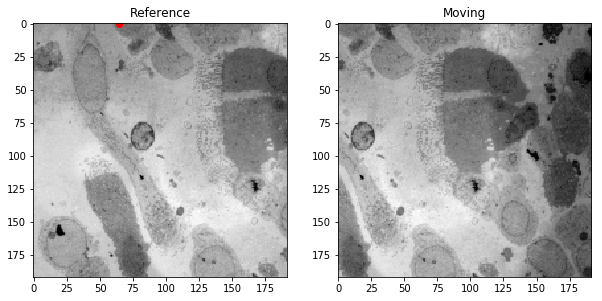

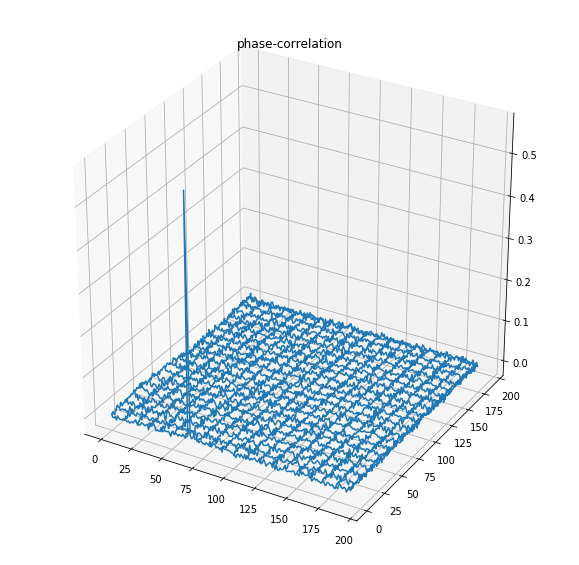

In [165]:
show_registration_3d(im1, im2, impulse, (x,y))

To corner to which `x` and `y` references is ambiguous. Why and how to solve this? 
- ~~do both images need to be padded?~~ Still ambiguous
- ✅ Do more checks just need to be made about which corner `x,y` is refering too? → perform some cross-correlation on the corners?

In [143]:
def prepare_paste(i1,i2, x,y):
    corner = test_corners(i1, i2, (y,x)) # tl, tr, bl, br
    padded = None
    if corner == 0: # top left corner
        row_p = y
        col_p = x
        padded = np.pad(i2, ((row_p,0), (col_p,0)), 'constant', constant_values=(0,0))
    elif corner == 1: # top right corner
        row_p = y
        col_p = max(i2.shape[1] - x, 0)
        padded = np.pad(i2, ((row_p,0), (0,col_p)), 'constant', constant_values=(0,0))
    elif corner == 2: # bottom right corner
        row_p = max(i2.shape[0] - y, 0)
        col_p = max(i2.shape[1] - x, 0)
        padded = np.pad(i2, ((0,row_p), (0,col_p)), 'constant', constant_values=(0,0))
    elif corner == 3: # bottom left corner
        row_p = max(i2.shape[0] - y, 0)
        col_p = x
        padded = np.pad(i2, ((0,row_p), (col_p,0)), 'constant', constant_values=(0,0))
    else:
        raise ValueError('This should never happen, corner=%d' % corner)
    return padded

(2150, 2150) (2150, 2150)
[1.0, 0.26688046982475905, -1, -1]
(2150, 4095) (2150, 4095) 0 0


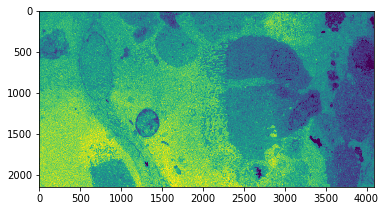

In [144]:
print(im1.shape, im2.shape)
im2 = prepare_paste(im1, im2, x, y)
base = paste(im1, im2)
plt.imshow(base)
plt.show()

1945 3123
1945 4095
[-1, 0.1189570572986026, 0.06533990573926715, -1]
(4095, 4095) (4095, 4095) 0 1945


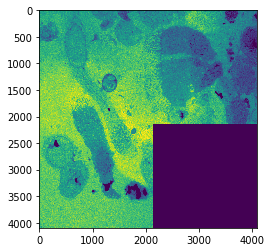

In [145]:
temp3 = Image.open('../data/T1_segment_3.tif')#.resize(newsize)
im3 = np.array(temp3).astype(dtype)
im3_2 = im3.copy()
im3 = bounds_equalize(base, im3)

impulse = ifft2(norm_cross_power_spectrum(base, im3))
y,x = np.unravel_index(np.argmax(impulse), impulse.shape)
print(y,x)
# due to the padding we need to shift the x and y
ny = y+int((im3.shape[0]-im3_2.shape[0])/2)
nx = x+int((im3.shape[1]-im3_2.shape[1])/2)
print(ny,nx)
im3_3 = prepare_paste(base, im3_2, nx, ny)
base2 = paste(base, im3_3)
plt.imshow(base2)
plt.show()

973 973
[1.0, 0.16797300362261378, 0.07725640880748053, -0.03197330334292754]


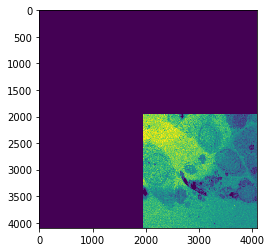

(4095, 4095) (4095, 4095) 0 0


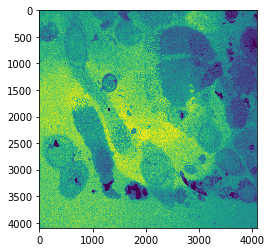

In [146]:
temp4 = Image.open('../data/T1_segment_4.tif')#.resize(newsize)
im4 = np.array(temp4).astype(dtype)
im4_2 = im4.copy()
im4 = bounds_equalize(base2, im4)

impulse = ifft2(norm_cross_power_spectrum(base2, im4))
y,x = np.unravel_index(np.argmax(impulse), impulse.shape)
print(y,x)
# due to the padding we need to shift the x and y
ny = y+int((im4.shape[0] - im4_2.shape[0])/2)
nx = x+int((im4.shape[1] - im4_2.shape[1])/2)
im4_3 = prepare_paste(base2, im4_2, nx, ny)
plt.imshow(im4_3)
plt.show()
base_final = paste(base2, im4_3)
plt.imshow(base_final)
plt.show()

## With rotation

There is no iterative technique here, instead a log-polar transform is performed on the images and a phase correlation is run on the two images. The peaks detected correspond to the scale and rotation of the moving image.

- [OpenCV docs: warpPolar](https://docs.opencv.org/3.4.2/da/d54/group__imgproc__transform.html#ga49481ab24fdaa0ffa4d3e63d14c0d5e4)

In [148]:
import cv2

def polar_log(img, radius=2.0):
    '''
    Use this warp if there is some scale difference and rotation
    '''
    center = (img.shape[0] / 2, img.shape[1] / 2)
    radius = round(math.sqrt(center[0] ** radius + center[1] ** radius))
    return cv2.warpPolar(img, img.shape, center, radius, cv2.WARP_POLAR_LOG)

def tuple_sub(t1, t2):
    return (t1[0] - t2[0], t1[1] - t2[1])

def bounds_equalize(target, ref):
    yd,xd = tuple_sub(target.shape, ref.shape)
    if yd < 0:
        ref = ref[-yd//2:yd//2,:]
    else:
        ref = np.pad(ref, ((yd//2,yd//2), (0,0)), 'constant', constant_values=(0,0))
        
    if xd < 0:
        ref = ref[:,-xd//2:xd//2]
    else:
        ref = np.pad(ref, ((0,0), (xd//2,xd//2)), 'constant', constant_values=(0,0))
        
    # there can be some off-by-one errors from division, make sure they're the same size
    if sum(tuple_sub(target.shape, ref.shape)) != 0:
        py = target.shape[0] - ref.shape[0] if target.shape[0] > ref.shape[0] else 0
        px = target.shape[1] - ref.shape[1] if target.shape[1] > ref.shape[1] else 0
        ref = np.pad(ref, ((0,py),(0,px)), 'constant', constant_values=(0,0))
        
    return ref
    

(3516, 3516) (3516, 3516)


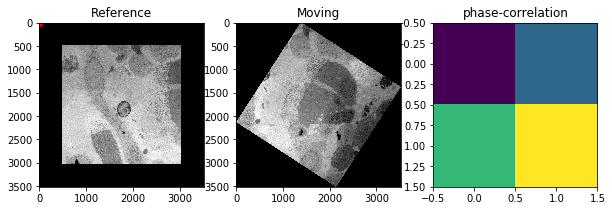

In [168]:
flags = cv2.IMREAD_UNCHANGED
temp1 = cv2.imread('../data/T1_segment_rot_1.tif', flags=flags).astype('float64')
temp2 = cv2.imread('../data/T1_segment_rot_2.tif', flags=flags).astype('float64')

temp1 = bounds_equalize(temp2, temp1)
print(temp1.shape, temp2.shape)

# these are resized inline
r = 1.0
new_size = (int(r * temp2.shape[0]), int(r * temp2.shape[1]))
temp1 = cv2.resize(temp1, new_size)
temp2 = cv2.resize(temp2, new_size)

show_registration(temp1, temp2, np.array([[1,2],[3,4]]), (0,0))

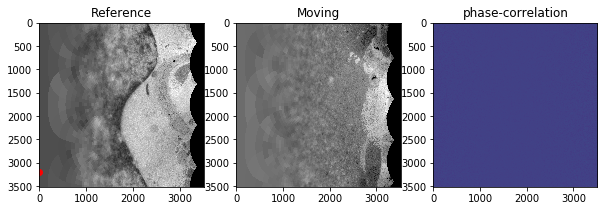

In [169]:
warp_fn = polar_log
im1_p = warp_fn(temp1)
im2_p = warp_fn(temp2)

impulse = ifft2(cross_power_spectrum(im1_p, im2_p))
theta, rho = np.unravel_index(np.argmax(impulse), impulse.shape)
show_registration(im1_p, im2_p, impulse, (rho, theta))

In [170]:
angle = theta * (360 / impulse.shape[0]) % 180
if angle < -90:
    angle += 180
elif angle > 90:
    angle -= 180
print(theta, rho, angle) # scale would be 1/(10 ** rho)

3194 0 -32.96928327645054


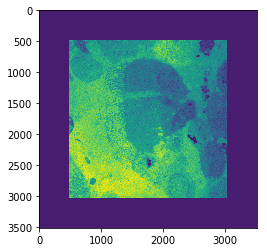

In [171]:
from scipy import ndimage
im2 = ndimage.rotate(temp2, -angle, reshape=False)

plt.imshow(im2)
plt.show()

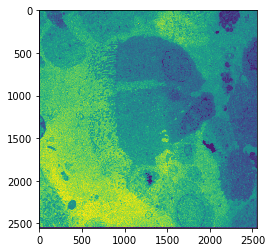

In [172]:
# we need to supply a zero argument, somehow the rotation is not clean.
plt.imshow(crop_zeros(im2, zero=100))
plt.show()